# Kaggle MNIST with fastai

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [178]:
import os
import numpy as np
import pandas as pd

from glob import glob
from pathlib import Path
from collections import Counter

import torch

from tqdm.auto import tqdm
from tqdm import tqdm_notebook
tqdm.pandas()

from skimage import img_as_int, img_as_uint, img_as_ubyte
from skimage.io import imshow, imsave

# For training
from fastai.vision import imagenet_stats
from fastai.vision import models as vision_models
from fastai.vision.data import ImageDataBunch, ImageList
from fastai.vision.learner import cnn_learner
from fastai.vision.transform import get_transforms
from fastai.metrics import error_rate, accuracy

# For interpretation
from fastai.train import ClassificationInterpretation

# For predictions
from fastai.basic_data import DatasetType
from fastai.basic_train import load_learner

NUM_CORES = 4
CSV_DATA_PATH = Path(os.path.join('data', 'mnist'))
IMAGE_DATA_PATH = CSV_DATA_PATH/'images'

### Unloading dataset

Execute following kaggle command to download the data under CSV_DATA_PATH

* kaggle competitions download -c digit-recognizer

In [3]:
df_train = pd.read_csv(CSV_DATA_PATH/'train.csv')
df_test = pd.read_csv(CSV_DATA_PATH/'test.csv')
df_train.shape, df_test.shape

((42000, 785), (28000, 784))

In [4]:
np.random.seed(21)

for sub_folder in ['train', 'valid', 'test']:
    if not os.path.isdir(IMAGE_DATA_PATH/sub_folder):
        os.mkdir(IMAGE_DATA_PATH/sub_folder)
        
def unload_images(df, valid_pct=0.2):
    
    columns_pixel = ["pixel{}".format(i) for i in range(784)]
    for row_idx in tqdm_notebook(range(df.shape[0])):
        image_ = img_as_ubyte(df.loc[row_idx, columns_pixel].values.reshape((28, 28)).astype('uint8'))
        
        if 'label' in df.columns:
            label = str(df.loc[row_idx, 'label'])
            
            if np.random.random() < valid_pct:
                img_path = IMAGE_DATA_PATH/'valid'/label
                if not os.path.isdir(img_path):
                    os.mkdir(img_path)
            else:
                img_path = IMAGE_DATA_PATH/'train'/label
                if not os.path.isdir(img_path):
                    os.mkdir(img_path)
                    
            imsave((img_path/"{}.jpg".format(row_idx)).__str__(), image_, check_contrast=False)
        else:
            imsave((IMAGE_DATA_PATH/'test'/"{}.jpg".format(row_idx)).__str__(), image_, check_contrast=False)
                
unload_images(df_train)
unload_images(df_test)

### Loading dataset

In [183]:
dataset = ImageDataBunch.from_folder(IMAGE_DATA_PATH, test='test', bs=64).normalize(imagenet_stats)

In [184]:
dataset

ImageDataBunch;

Train: LabelList (33660 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
4,4,4,4,4
Path: data/mnist/images;

Valid: LabelList (8340 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
4,4,4,4,4
Path: data/mnist/images;

Test: LabelList (28000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: EmptyLabelList
,,,,
Path: data/mnist/images

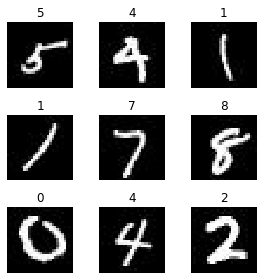

In [15]:
dataset.show_batch(rows=3, figsize=(4, 4))

In [16]:
print(dataset.classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [17]:
print(dataset.c)

10


### Training Model

In [181]:
learn = cnn_learner(dataset, vision_models.resnet34, metrics=[accuracy, error_rate])

In [19]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.935373,0.664884,0.791727,0.208273,00:41
1,0.465868,0.314397,0.900839,0.099161,00:41
2,0.264967,0.185237,0.941966,0.058034,00:41
3,0.196934,0.134004,0.958153,0.041847,00:42
4,0.135325,0.109522,0.965108,0.034892,00:42
5,0.130350,0.109374,0.965947,0.034053,00:40


In [20]:
learn.save('resnet34_mnist', return_path=True)

In [21]:
learn = cnn_learner(dataset, vision_models.resnet18, metrics=[accuracy, error_rate])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/ubuntu/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 23.9MB/s]


In [22]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.028063,0.704321,0.778297,0.221703,00:27
1,0.527906,0.348104,0.894365,0.105635,00:28
2,0.325403,0.215548,0.931415,0.068585,00:28
3,0.227931,0.148976,0.953597,0.046403,00:28
4,0.183427,0.131278,0.959592,0.040408,00:28
5,0.174353,0.127332,0.960791,0.039209,00:28


In [23]:
learn.save('resnet18_mnist', return_path=True)

PosixPath('data/mnist/images/models/resnet18_mnist.pth')

### Prediction interpretation

In [185]:
learn = cnn_learner(dataset, vision_models.resnet34, metrics=[accuracy, error_rate])
learn.load('resnet34_mnist');

In [27]:
cls_interpreter = ClassificationInterpretation.from_learner(learn)

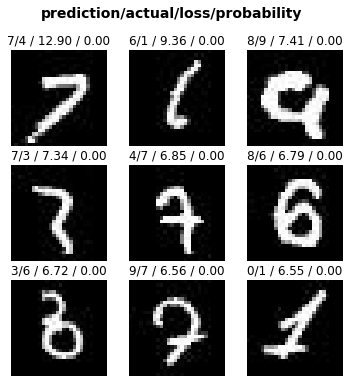

In [32]:
cls_interpreter.plot_top_losses(k=9, figsize=(6, 6))

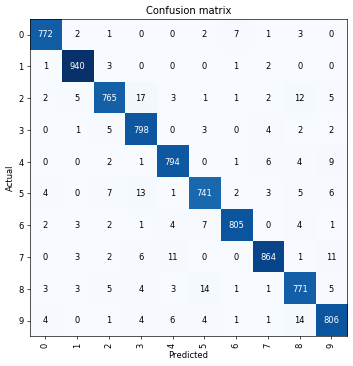

In [34]:
cls_interpreter.plot_confusion_matrix(figsize=(6, 6), dpi=60)

In [35]:
cls_interpreter.most_confused(min_val=6)

[('2', '3', 17),
 ('8', '5', 14),
 ('9', '8', 14),
 ('5', '3', 13),
 ('2', '8', 12),
 ('7', '4', 11),
 ('7', '9', 11),
 ('4', '9', 9),
 ('0', '6', 7),
 ('5', '2', 7),
 ('6', '5', 7),
 ('4', '7', 6),
 ('5', '9', 6),
 ('7', '3', 6),
 ('9', '4', 6)]

### Optimizing learning rate

In [36]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


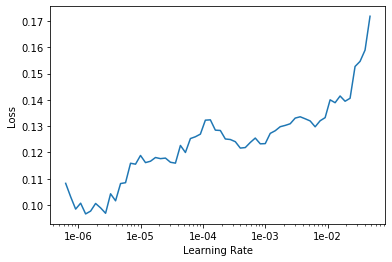

In [37]:
learn.recorder.plot()

In [41]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-06, 1e-03))

epoch,train_loss,valid_loss,accuracy,error_rate,time
epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.106607,0.088940,0.972542,0.027458,00:55
0,0.106607,0.088940,0.972542,0.027458,00:55
1,0.075111,0.057520,0.983333,0.016667,00:54
1,0.075111,0.057520,0.983333,0.016667,00:54
2,0.048238,0.048072,0.984652,0.015348,00:55
2,0.048238,0.048072,0.984652,0.015348,00:55
3,0.024405,0.047467,0.984652,0.015348,00:55
3,0.024405,0.047467,0.984652,0.015348,00:55


In [138]:
learn.save('resnet34_mnist', return_path=True)

PosixPath('data/mnist/images/models/resnet34_mnist.pth')

In [139]:
cls_interpreter = ClassificationInterpretation.from_learner(learn)

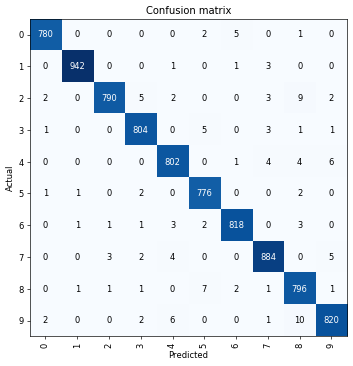

In [140]:
cls_interpreter.plot_confusion_matrix(figsize=(6, 6), dpi=60)

### Export learner

In [148]:
learn.export('resnet34_mnist.pkl')

### Creating submission file

In [164]:
df_test = pd.DataFrame(list(map(lambda f: f.split(os.sep)[-1], glob(str(IMAGE_DATA_PATH/'test/*.jpg')))), columns=['name'])
df_test['sort_order'] = df_test['name'].map(lambda f: int(f.split('.')[0]))
df_test = df_test.sort_values('sort_order').copy()
df_test.reset_index(drop=True, inplace=True)
df_test.head()

,name,sort_order
0,0.jpg,0
1,1.jpg,1
2,2.jpg,2
3,3.jpg,3
4,4.jpg,4


In [165]:
il_test = ImageList.from_df(df_test, IMAGE_DATA_PATH/'test')
il_test

ImageList (28000 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: data/mnist/images/test

In [168]:
# Need to raise GITHUB ISSUE,

# learn_final = load_learner(IMAGE_DATA_PATH, file='resnet34_mnist.pkl', test=il_test) 
# # preds, _ = learner.get_preds(ds_type=DatasetType.Test)

# AttributeError                            Traceback (most recent call last)
# <ipython-input-160-f5d0e1dd5a47> in <module>
# ----> 1 learn_final = load_learner(IMAGE_DATA_PATH, file='resnet34_mnist.pkl', test=il_test)
#       2 # preds, _ = learner.get_preds(ds_type=DatasetType.Test)

# ~/anaconda3/lib/python3.7/site-packages/fastai/basic_train.py in load_learner(path, file, test, **db_kwargs)
#     626     res = clas_func(data, model, **state)
#     627     res.callback_fns = state['callback_fns'] #to avoid duplicates
# --> 628     res.callbacks = [load_callback(c,s, res) for c,s in cb_state.items()]
#     629     return res

# ~/anaconda3/lib/python3.7/site-packages/fastai/basic_train.py in <listcomp>(.0)
#     626     res = clas_func(data, model, **state)
#     627     res.callback_fns = state['callback_fns'] #to avoid duplicates
# --> 628     res.callbacks = [load_callback(c,s, res) for c,s in cb_state.items()]
#     629     return res

# ~/anaconda3/lib/python3.7/site-packages/fastai/basic_train.py in load_callback(class_func, state, learn)
#     610 def load_callback(class_func, state, learn:Learner):
#     611     init_kwargs, others = split_kwargs_by_func(state, class_func.__init__)
# --> 612     res = class_func(learn, **init_kwargs) if issubclass(class_func, LearnerCallback) else class_func(**init_kwargs)
#     613     for k,v in others.items(): setattr(res, k, v)
#     614     return res

# ~/anaconda3/lib/python3.7/site-packages/fastai/basic_train.py in __init__(self, learn, add_time, silent)
#     459     def __init__(self, learn:Learner, add_time:bool=True, silent:bool=False):
#     460         super().__init__(learn)
# --> 461         self.opt = self.learn.opt
#     462         self.train_dl = self.learn.data.train_dl
#     463         self.no_val,self.silent,self.add_time = False,silent,add_time

# AttributeError: 'Learner' object has no attribute 'opt'

In [172]:
learn.data.test_ds.x = il_test

In [173]:
y_pred_probs, _ = learn.get_preds(DatasetType.Test)

In [174]:
y_pred = torch.argmax(y_pred_probs, dim=1)

In [175]:
df_submission = pd.DataFrame(y_pred.numpy(), columns=['Label'])
df_submission['ImageId'] = range(1, df_submission.shape[0] + 1)
df_submission.head()

,Label,ImageId
0,2,1
1,0,2
2,9,3
3,0,4
4,3,5


In [177]:
df_submission.to_csv(CSV_DATA_PATH/'submission.csv', index=False)